In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import precision_recall_curve, auc, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Function to load data and prepare X, y
filepath = "../data/cleaned"
def load_data(filepath, target_col):
    df = pd.read_csv(filepath)
    X = df.drop(columns=[target_col])
    y = df[target_col]
    return X, y

# Load datasets
X_credit, y_credit = load_data('../data/cleaned/cleaned_creditcard_df.csv', 'Class')
X_fraud, y_fraud = load_data('../data/cleaned/cleaned_fraud_df.csv', 'class')

# Train-test split function
def split_data(X, y):
    return train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Split both datasets
X_train_credit, X_test_credit, y_train_credit, y_test_credit = split_data(X_credit, y_credit)
X_train_fraud, X_test_fraud, y_train_fraud, y_test_fraud = split_data(X_fraud, y_fraud)

# Initialize models
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)


In [3]:
print("Remaining object or datetime columns in X_train_fraud:")
print(X_train_fraud.select_dtypes(include=['object', 'datetime']).columns.tolist())

Remaining object or datetime columns in X_train_fraud:
['signup_time', 'purchase_time', 'device_id', 'source', 'browser', 'sex', 'country']


Evaluating models on Credit Card Fraud dataset



c:\PY\fraud-detection-ecommerce-bank\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


--- Credit Card - Logistic Regression ---
AUC-PR: 0.6824
F1 Score: 0.0889
Confusion Matrix:
[[54961  1690]
 [   12    83]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     56651
           1       0.05      0.87      0.09        95

    accuracy                           0.97     56746
   macro avg       0.52      0.92      0.54     56746
weighted avg       1.00      0.97      0.98     56746





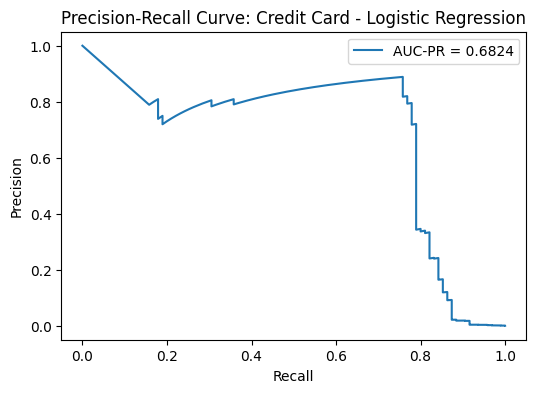

c:\PY\fraud-detection-ecommerce-bank\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:43:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


--- Credit Card - XGBoost ---
AUC-PR: 0.7502
F1 Score: 0.7667
Confusion Matrix:
[[56635    16]
 [   26    69]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.81      0.73      0.77        95

    accuracy                           1.00     56746
   macro avg       0.91      0.86      0.88     56746
weighted avg       1.00      1.00      1.00     56746





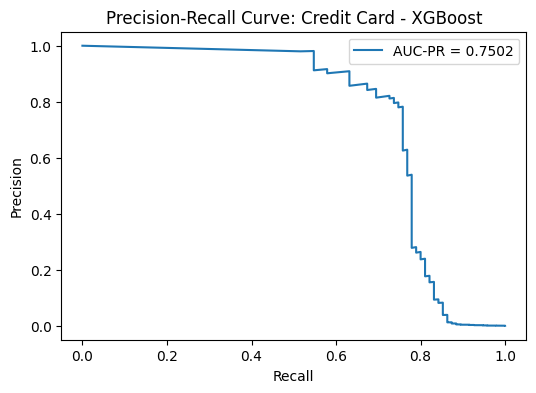

Evaluating models on Ecommerce Fraud dataset



ValueError: could not convert string to float: '2015-07-17 16:58:56'

In [4]:
# Helper function to train and evaluate models
def train_evaluate_model(X_train, y_train, X_test, y_test, model, dataset_name, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:,1]

    precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
    auc_pr = auc(recall, precision)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    print(f"--- {dataset_name} - {model_name} ---")
    print(f"AUC-PR: {auc_pr:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("Confusion Matrix:")
    print(cm)
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("\n")

    # Plot PR curve
    plt.figure(figsize=(6,4))
    plt.plot(recall, precision, label=f'AUC-PR = {auc_pr:.4f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve: {dataset_name} - {model_name}')
    plt.legend()
    plt.show()

    return auc_pr, f1, cm

# Train and evaluate on Credit Card Fraud dataset
print("Evaluating models on Credit Card Fraud dataset\n")
log_auc_pr_credit, log_f1_credit, log_cm_credit = train_evaluate_model(
    X_train_credit, y_train_credit, X_test_credit, y_test_credit, log_reg, "Credit Card", "Logistic Regression"
)

xgb_auc_pr_credit, xgb_f1_credit, xgb_cm_credit = train_evaluate_model(
    X_train_credit, y_train_credit, X_test_credit, y_test_credit, xgb, "Credit Card", "XGBoost"
)

# Train and evaluate on Ecommerce Fraud dataset
print("Evaluating models on Ecommerce Fraud dataset\n")
log_auc_pr_fraud, log_f1_fraud, log_cm_fraud = train_evaluate_model(
    X_train_fraud, y_train_fraud, X_test_fraud, y_test_fraud, log_reg, "Ecommerce Fraud", "Logistic Regression"
)

xgb_auc_pr_fraud, xgb_f1_fraud, xgb_cm_fraud = train_evaluate_model(
    X_train_fraud, y_train_fraud, X_test_fraud, y_test_fraud, xgb, "Ecommerce Fraud", "XGBoost"
)

# Summary table
summary_df = pd.DataFrame({
    'Dataset': ['Credit Card', 'Credit Card', 'Ecommerce Fraud', 'Ecommerce Fraud'],
    'Model': ['Logistic Regression', 'XGBoost', 'Logistic Regression', 'XGBoost'],
    'AUC-PR': [log_auc_pr_credit, xgb_auc_pr_credit, log_auc_pr_fraud, xgb_auc_pr_fraud],
    'F1-Score': [log_f1_credit, xgb_f1_credit, log_f1_fraud, xgb_f1_fraud]
})

print("Summary of Model Performance:")
print(summary_df)

# justification after comparing the results.
